Launching Firefox…
Navigating to search page…
Filling Last Name…
Clicking real Search button…
Waiting for results table…
Results loaded!


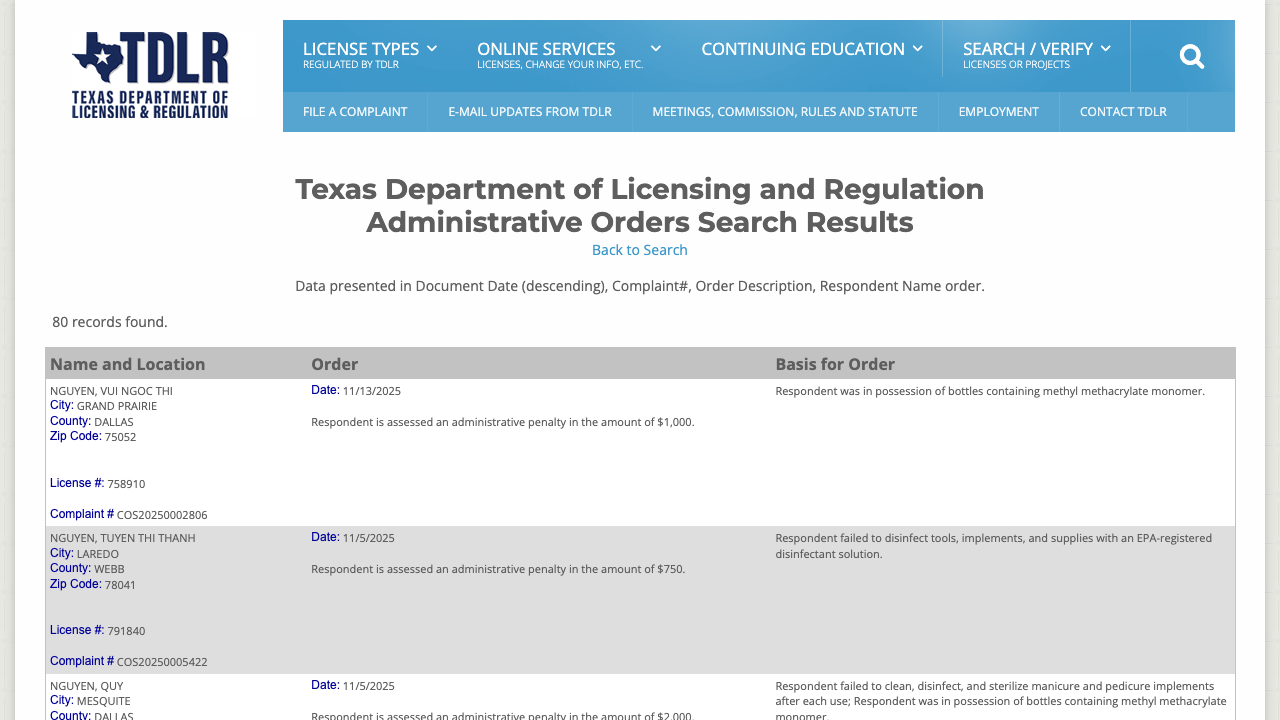

Extracting HTML…
Found 80 data rows.


Parsing rows:   0%|          | 0/80 [00:00<?, ?row/s]

Browser closed. Complete!


,Name and Location,Order,Basis for Order
0,"NGUYEN, VUI NGOC THI | City: | GRAND PRAIRIE |...",Date:11/13/2025Respondent is assessed an admin...,Respondent was in possession of bottles contai...
1,"NGUYEN, TUYEN THI THANH | City: | LAREDO | Cou...",Date:11/5/2025Respondent is assessed an admini...,"Respondent failed to disinfect tools, implemen..."
2,"NGUYEN, QUY | City: | MESQUITE | County: | DAL...",Date:11/5/2025Respondent is assessed an admini...,"Respondent failed to clean, disinfect, and ste..."
3,"NGUYEN, NAM QUANG | City: | HARKER HEIGHTS | C...",Date:10/30/2025Respondent is assessed an admin...,"Respondent failed to clean, disinfect, and ste..."
4,"NGUYEN, KEVIN C | City: | KYLE | County: | HAY...",Date:10/6/2025Respondent is assessed an admini...,Respondent employed an individual as an operat...


In [17]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display, Image

async def scrape_tdlr_nguyen():
    async with async_playwright() as p:
        print("Launching Firefox…")
        browser = await p.firefox.launch(headless=False)
        context = await browser.new_context()
        page = await context.new_page()

        print("Navigating to search page…")
        await page.goto("https://www.tdlr.texas.gov/cimsfo/fosearch.asp", wait_until="networkidle")

        print("Filling Last Name…")
        await page.fill("input[name='pht_lnm']", "NGUYEN")

        print("Clicking real Search button…")
        await page.click("input[type='submit'][name='B1'][value='Search']")

        print("Waiting for results table…")
        await page.wait_for_selector("th:has-text('Name and Location')", timeout=60000)
        print("Results loaded!")

        # Screenshot to verify
        screenshot = await page.screenshot()
        display(Image(screenshot))

        print("Extracting HTML…")
        content = await page.content()
        soup = BeautifulSoup(content, "html.parser")

        # Find the results table by header text
        header = soup.find("th", string=lambda x: x and "Name and Location" in x)
        table = header.find_parent("table")

        rows = table.find_all("tr")[1:]  # skip header row
        print(f"Found {len(rows)} data rows.")

        # -------------------------
        # PROGRESS BAR (visible)
        # -------------------------
        data = []
        for row in tqdm(rows, desc="Parsing rows", unit="row"):
            cols = row.find_all("td")
            if len(cols) >= 3:
                # Extract multiple spans in first column
                name_loc = " | ".join(
                    span.get_text(strip=True) 
                    for span in cols[0].find_all("span")
                )
                order = cols[1].get_text(strip=True)
                basis = cols[2].get_text(strip=True)

                data.append({
                    "Name and Location": name_loc,
                    "Order": order,
                    "Basis for Order": basis
                })

        df = pd.DataFrame(data)

        await browser.close()
        print("Browser closed. Complete!")

        return df


# Run the scraper in Jupyter
df = await scrape_tdlr_nguyen()

df.head()
